## LITL Eval

We see how the Gemini (No LITL), Gemini (With LITL), and Grok (With LITL) compare for predicting compound efficacy. Note that we redact each compound with a FB code to protect proprietary data.

In [1]:
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
gemini_no_lit_results_path = "0__gemini__before_litl_results.pkl"
gemini_lit_results_path = "2__gemini__after_litl_results.pkl"
grok_lit_results_path = "2__grok__after_litl_results.pkl"

with open(gemini_no_lit_results_path, "rb") as f:
    gemini_no_lit_results = pickle.load(f)

with open(gemini_lit_results_path, "rb") as f:
    gemini_lit_results = pickle.load(f)

with open(grok_lit_results_path, "rb") as f:
    grok_lit_results = pickle.load(f)

/var/folders/pc/dx9_5lnn3qz8j56zyhdcmk8w0000gn/T/ipykernel_60022/3188486458.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


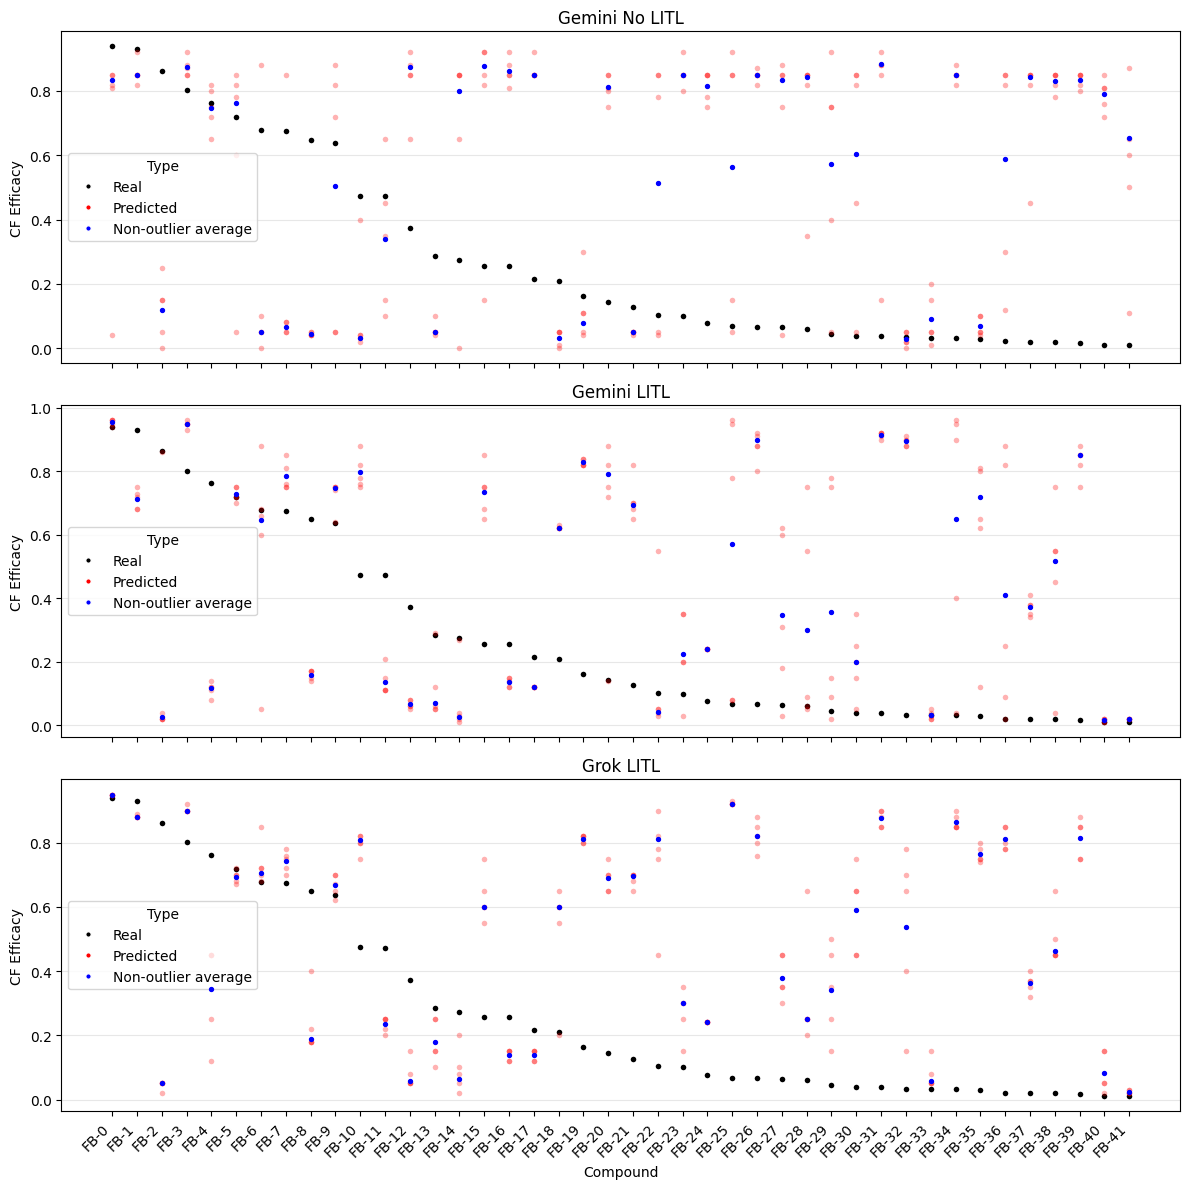

In [3]:
# Function to prepare data
def prepare_data(results, is_summarized=False):
    data = []
    real_added = set()
    for item in results:
        if is_summarized:
            example, prediction, predicted = item
        else:
            example, prediction = item
        compound = example.compound_name
        real = example.cf_efficacy
        if compound not in real_added:
            data.append({"compound": compound, "type": "real", "efficacy": real})
            real_added.add(compound)
        data.append(
            {
                "compound": compound,
                "type": "predicted",
                "efficacy": prediction.predicted_efficacy,
            }
        )
    df = pd.DataFrame(data)
    compound_order = (
        df[df["type"] == "real"]
        .sort_values("efficacy", ascending=False)["compound"]
        .tolist()
    )
    return df, compound_order


# Prepare data for each
df1, order1 = prepare_data(gemini_no_lit_results["agent_runs"])
df2, order2 = prepare_data(gemini_lit_results["agent_runs"])
df3, order3 = prepare_data(grok_lit_results["agent_runs"])

# Create mapping from real compound names to redacted names
compound_to_redacted = {comp: f"FB-{i}" for i, comp in enumerate(order1)}

# Apply redaction to dataframes
df1["compound"] = df1["compound"].map(compound_to_redacted)
df2["compound"] = df2["compound"].map(compound_to_redacted)
df3["compound"] = df3["compound"].map(compound_to_redacted)

# Update orders with redacted names
order1 = [compound_to_redacted[comp] for comp in order1]
order2 = [compound_to_redacted[comp] for comp in order2]
order3 = [compound_to_redacted[comp] for comp in order3]


def non_outlier_mean(series):
    if len(series) <= 2:
        return series.mean()
    sorted_vals = sorted(series)
    n = len(sorted_vals)
    q1_idx = n // 4
    q3_idx = 3 * n // 4
    q1 = sorted_vals[q1_idx]
    q3 = sorted_vals[q3_idx]
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = series[(series >= lower) & (series <= upper)]
    return filtered.mean() if len(filtered) > 0 else series.mean()


def get_errors(df, order):
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    real_df = df[df["type"] == "real"].set_index("compound")["efficacy"]
    errors = {comp: real_df.get(comp, 0) - mean_pred.get(comp, 0) for comp in order}
    return errors


error1 = get_errors(df1, order1)
error2 = get_errors(df2, order2)
error3 = get_errors(df3, order3)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

titles = ["Gemini No LITL", "Gemini LITL", "Grok LITL"]
dfs_orders = [(df1, order1), (df2, order2), (df3, order3)]

for i in range(3):
    ax = axes[i]
    title = titles[i]
    ax.set_title(title)
    df, order = dfs_orders[i]
    # Plot real with full opacity
    sns.stripplot(
        data=df[df["type"] == "real"],
        x="compound",
        y="efficacy",
        color="black",
        order=order,
        jitter=False,
        size=4,
        alpha=1,
        ax=ax,
    )

    # Plot predicted with 0.3 opacity
    sns.stripplot(
        data=df[df["type"] == "predicted"],
        x="compound",
        y="efficacy",
        color="red",
        order=order,
        jitter=False,
        size=4,
        alpha=0.3,
        ax=ax,
    )

    # Calculate and plot average predicted
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    for j, comp in enumerate(order):
        if comp in mean_pred:
            ax.scatter(j, mean_pred[comp], color="blue", s=8, zorder=10)

    # Add legend
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="black",
            markersize=4,
            label="Real",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="red",
            markersize=4,
            label="Predicted",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="blue",
            markersize=4,
            label="Non-outlier average",
        ),
    ]
    ax.legend(handles=handles, title="Type")
    ax.set_ylabel("CF Efficacy")

    if i == 2:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("Compound")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/pc/dx9_5lnn3qz8j56zyhdcmk8w0000gn/T/ipykernel_60022/178851995.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


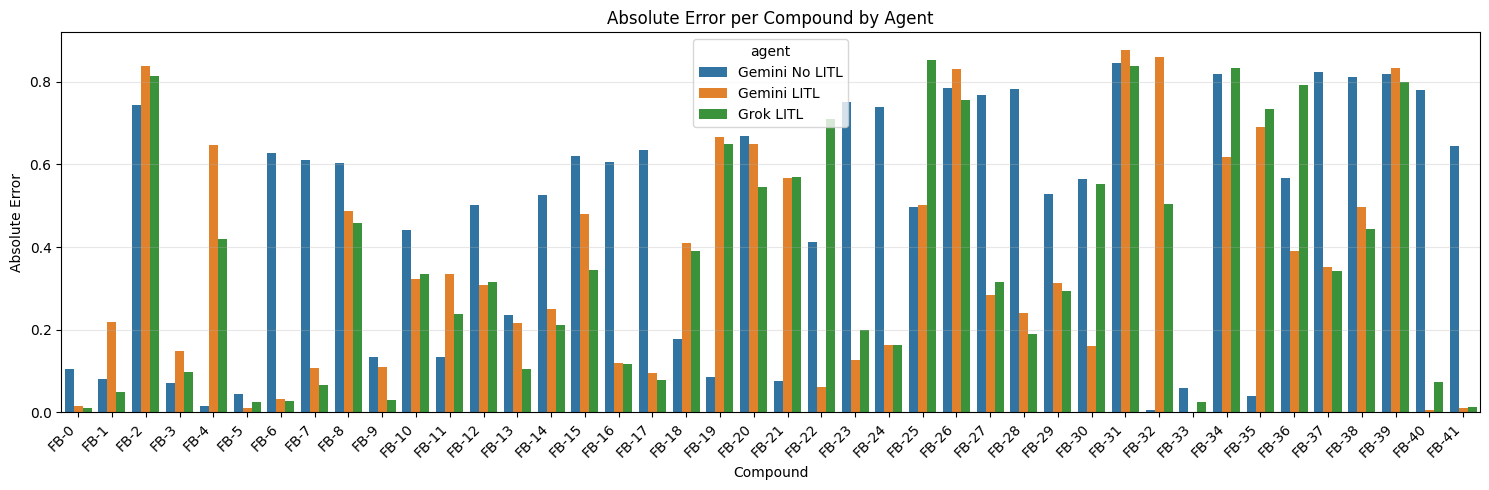

In [4]:
# Change in Error Plots

abs_errors = []
for comp in order1:
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Gemini No LITL",
            "abs_error": abs(error1.get(comp, 0)),
        }
    )
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Gemini LITL",
            "abs_error": abs(error2.get(comp, 0)),
        }
    )
    abs_errors.append(
        {
            "compound": comp,
            "agent": "Grok LITL",
            "abs_error": abs(error3.get(comp, 0)),
        }
    )

abs_error_df = pd.DataFrame(abs_errors)

fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(
    data=abs_error_df, x="compound", y="abs_error", hue="agent", order=order1, ax=ax
)
ax.set_title("Absolute Error per Compound by Agent")
ax.set_ylabel("Absolute Error")
ax.set_xlabel("Compound")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

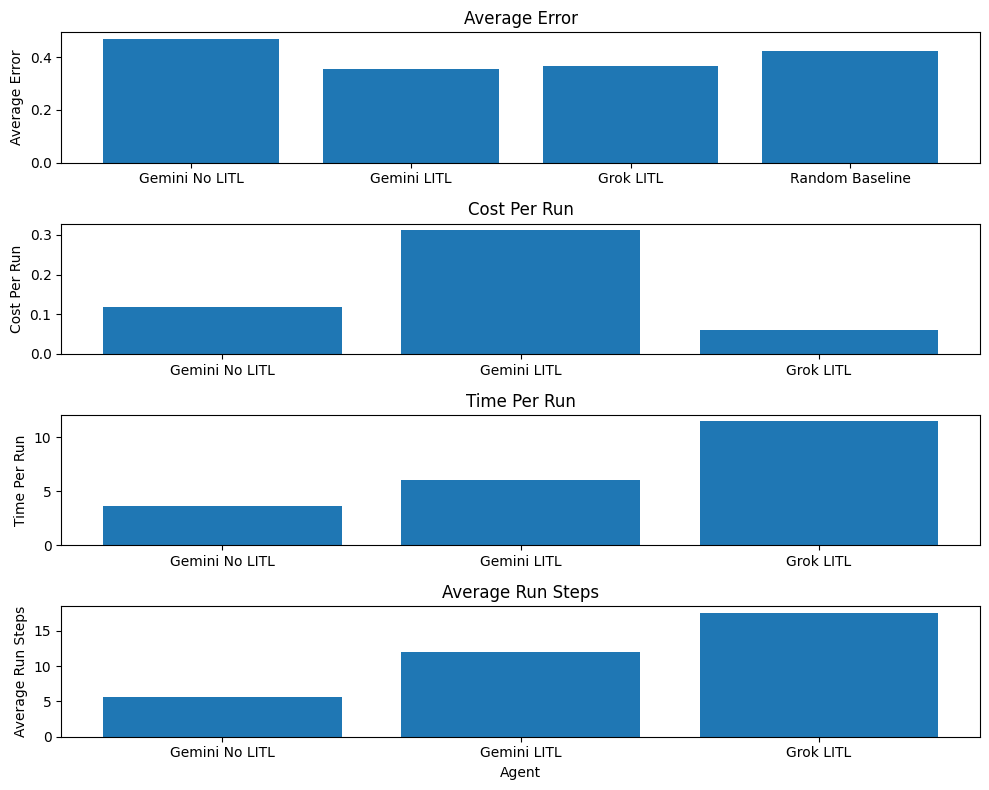

In [5]:
# Agent Comparison Metrics

import numpy as np

avg_errors = [
    np.mean([abs(v) for v in error1.values()]),
    np.mean([abs(v) for v in error2.values()]),
    np.mean([abs(v) for v in error3.values()]),
]


# Calculate average run steps
def get_avg_steps(results, is_summarized=False):
    steps_list = []
    for item in results:
        if is_summarized:
            example, prediction, predicted = item
        else:
            example, prediction = item
        steps = len(prediction.trajectory) // 4
        steps_list.append(steps)
    return np.mean(steps_list)


avg_steps1 = get_avg_steps(gemini_no_lit_results["agent_runs"])
avg_steps2 = get_avg_steps(gemini_lit_results["agent_runs"])
avg_steps3 = get_avg_steps(grok_lit_results["agent_runs"])

run_steps = [avg_steps1, avg_steps2, avg_steps3]

# Actual costs and times
num_runs1 = len(gemini_no_lit_results["agent_runs"])
num_runs2 = len(gemini_lit_results["agent_runs"])
num_runs3 = len(grok_lit_results["agent_runs"])

costs = [
    gemini_no_lit_results["cost"] / num_runs1,
    gemini_lit_results["cost"] / num_runs2,
    grok_lit_results["cost"] / num_runs3,
]

times = [
    gemini_no_lit_results["time"] / num_runs1,
    gemini_lit_results["time"] / num_runs2,
    grok_lit_results["time"] / num_runs3,
]

agents = ["Gemini No LITL", "Gemini LITL", "Grok LITL"]
metrics = [
    "Average Error",
    "Cost Per Run",
    "Time Per Run",
    "Average Run Steps",
]
values = [avg_errors, costs, times, run_steps]

# Random baseline
import random

random.seed(0)
real_df = df1[df1["type"] == "real"].set_index("compound")["efficacy"]
random_errors = []
for comp in order1:
    real = real_df.get(comp, 0)
    random_pred = random.uniform(0, 1)
    error = real - random_pred
    random_errors.append(abs(error))
random_avg_error = np.mean(random_errors)

avg_errors.append(random_avg_error)
costs.append(np.nan)
times.append(np.nan)
run_steps.append(np.nan)
agents.append("Random Baseline")

fig, axes = plt.subplots(4, 1, figsize=(10, 8))

for i in range(4):
    ax = axes[i]
    ax.bar(agents, values[i])
    ax.set_title(metrics[i])
    ax.set_ylabel(metrics[i])
    if i == 3:
        ax.set_xlabel("Agent")

plt.tight_layout()
plt.show()

### Hit Prediction Accuracy

Given an arbitrary hit threshold of 0.6 for efficacy, how well does each LITL system predict hit and non-hit compounds?

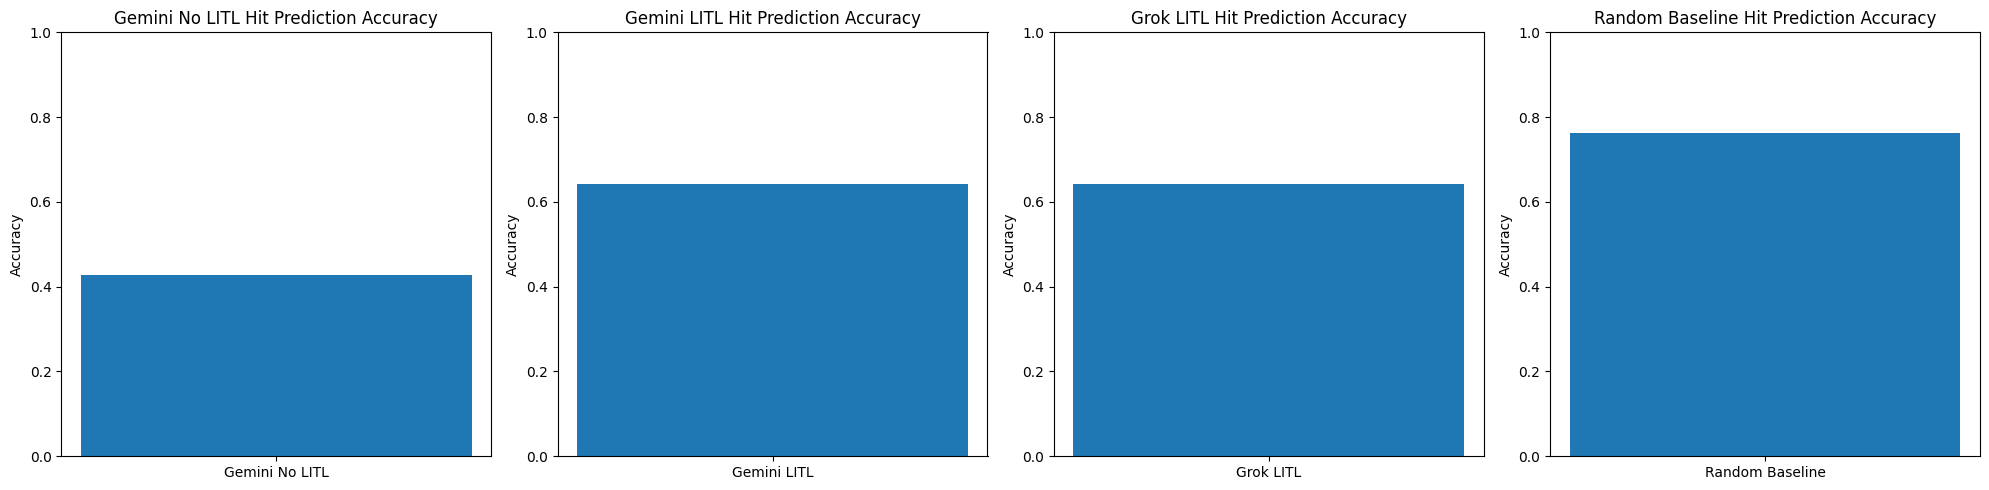

In [6]:
# Hit Prediction Accuracy


def compute_accuracy(df, order):
    mean_pred = (
        df[df["type"] == "predicted"]
        .groupby("compound")["efficacy"]
        .apply(non_outlier_mean)
    )
    real_df = df[df["type"] == "real"].set_index("compound")["efficacy"]
    correct = 0
    total = 0
    for comp in order:
        if comp in mean_pred.index and comp in real_df.index:
            pred_hit = mean_pred[comp] > 0.6
            real_hit = real_df[comp] > 0.6
            if pred_hit == real_hit:
                correct += 1
            total += 1
    return correct / total if total > 0 else 0


acc1 = compute_accuracy(df1, order1)
acc2 = compute_accuracy(df2, order2)
acc3 = compute_accuracy(df3, order3)

# Random baseline
random.seed(0)
real_df = df1[df1["type"] == "real"].set_index("compound")["efficacy"]
correct = 0
total = 0
for comp in order1:
    real = real_df.get(comp, 0)
    random_preds = [random.uniform(0, 1) for _ in range(100)]
    mean_pred = non_outlier_mean(pd.Series(random_preds))
    pred_hit = mean_pred > 0.6
    real_hit = real > 0.6
    if pred_hit == real_hit:
        correct += 1
    total += 1
acc4 = correct / total if total > 0 else 0

agents = ["Gemini No LITL", "Gemini LITL", "Grok LITL", "Random Baseline"]
accuracies = [acc1, acc2, acc3, acc4]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axes[i].bar([agents[i]], [accuracies[i]])
    axes[i].set_title(f"{agents[i]} Hit Prediction Accuracy")
    axes[i].set_ylabel("Accuracy")
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()